In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import os

import numpy as np
import pandas as pd
import tensorflow as tf

import atecml.data

from contextlib import contextmanager
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegressionCV
#build Models...
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from imblearn.over_sampling import SMOTE, ADASYN
import copy as copy
import random

plt.style.use('ggplot')

In [14]:
def lgb_modelfit_nocv(params, dtrain, dvalid, predictors, target='target', objective='binary', metrics='binary_error',
                 feval=None, early_stopping_rounds=20, num_boost_round=3000, verbose_eval=10, categorical_features=None):
    lgb_params = {
        'boosting_type': 'rf',
        #'drop_rate' : 0.2, #Dart Only, DropoutRate
        'objective': objective,
        'use_missing' : 'true',
        'learning_rate': 0.15,
        #'is_unbalance': 'true',  #because training data is unbalance (replaced with scale_pos_weight)
        'num_leaves': 64,  # we should let it be smaller than 2^(max_depth)
        'max_depth': -1,  # -1 means no limit
        'min_child_samples': 600,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 255,  # Number of bucketed bin for feature values
        'feature_fraction': 0.7,
        'subsample': 0.85,  # Subsample ratio of the training instance.
        'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
        'min_child_weight': 0.05,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'subsample_for_bin': 2000,  # Number of samples for constructing bin
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'reg_alpha': 5,  # L1 regularization term on weights
        'reg_lambda': 10,  # L2 regularization term on weights
        'nthread': 40,
        'verbose': 0,
        'scale_pos_weight' : 0.01,
        'metric':metrics
    }

    lgb_params.update(params)
    print("preparing validation datasets")

    xgtrain = lgb.Dataset(dtrain[predictors].values, label=dtrain[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )
    xgvalid = lgb.Dataset(dvalid[predictors].values, label=dvalid[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )

    evals_results = {}

    bst1 = lgb.train(lgb_params, 
                     xgtrain, 
                     valid_sets=[xgtrain, xgvalid], 
                     valid_names=['train','valid'], 
                     evals_result=evals_results, 
                     num_boost_round=num_boost_round,
                     early_stopping_rounds=early_stopping_rounds,
                     verbose_eval=verbose_eval, 
                     feval=feval)

    return bst1

def model_validation(train_df,val_df,predictors,target,params):
    categorical=[]
    for item in predictors:
        if (item in atecml.data.CATE_FEATURE_LIST):
            categorical.append(item)
            
    if (target == 'Normal'):
        params = {
            'scale_pos_weight' : 0.01,
        } 
    else:
        params = {
            'scale_pos_weight' : 99,
        }
    bst = lgb_modelfit_nocv(params, 
                        train_df, 
                        val_df, 
                        predictors, 
                        target, 
                        objective='binary', 
                        metrics='auc',
                        early_stopping_rounds=100, 
                        verbose_eval=50, 
                        num_boost_round=50, 
                        categorical_features=categorical
                        )
    y_predict = bst.predict(val_df[predictors])
    if (target == 'Normal'):
        y_predict = 1 - y_predict
    atec_Score,b,c=atecml.data.accuracy_validation(val_df['Fraud'],y_predict)
    return bst,atec_Score

In [15]:
data = atecml.data.load_train()



In [16]:
'''def feature_extraction(df):
    date_list = list(set(df['date']))
    tdf_list = []
    with atecml.data.timer('Generate New F210 by DateMean'):
        for idx in tqdm(range(len(date_list))):
            date = date_list[idx]
            tdf = df[df['date'] == date]
            tdf['new_f210']  =tdf['f210'] - tdf['f210'].mean()
            tdf_list.append(tdf)
        result = pd.concat(tdf_list)
    return result.sort_index()

data = feature_extraction(data)
'''

"def feature_extraction(df):\n    date_list = list(set(df['date']))\n    tdf_list = []\n    with atecml.data.timer('Generate New F210 by DateMean'):\n        for idx in tqdm(range(len(date_list))):\n            date = date_list[idx]\n            tdf = df[df['date'] == date]\n            tdf['new_f210']  =tdf['f210'] - tdf['f210'].mean()\n            tdf_list.append(tdf)\n        result = pd.concat(tdf_list)\n    return result.sort_index()\n\ndata = feature_extraction(data)\n"

In [17]:
train_df = atecml.data.filter_date(data,start_date='2017-09-05',end_date='2017-10-15')
val_df = atecml.data.filter_date(data,start_date='2017-10-16',end_date='2018-10-15')

In [18]:
predictors = [x for x in train_df.columns if x not in atecml.data.NOT_FEATURE_SUM]
#model_pos,score_pos = model_validation(train_df,val_df,predictors,'Normal',{})
#model_neg,score_neg = model_validation(train_df,val_df,predictors,'Fraud',{})

In [19]:
predictors = [x for x in train_df.columns if x not in atecml.data.NOT_FEATURE_SUM]
imp_feature = ['f7', 'f210', 'f248', 'f5', 'f82', 'f6', 'f238', 'f30', 'f234', 'f244', 'f106', 'f253', 'f215', 'f84', 'f52', 'f15', 'f243', 'f31', 'f29', 'f53']
predictors_wo_imp = [x for x in predictors if x not in imp_feature]

In [20]:
feature_tree_num = 100
print('Generate Random Feature List...')
feature_list = {}
for idx in range(0,feature_tree_num):
    feature_set = set(random.sample(predictors,70))
    feature_list[idx] = list(feature_set)
    #feature_set = set(random.sample(predictors_wo_imp,40))
    #feature_list[idx] = imp_feature + list(feature_set)
#joblib.dump(feature_list,'./feature_list.dat')


Generate Random Feature List...


In [21]:
idx =3

preparing validation datasets
Training until validation scores don't improve for 100 rounds.
[50]	train's auc: 0.950329	valid's auc: 0.949222
Did not meet early stopping. Best iteration is:
[46]	train's auc: 0.950383	valid's auc: 0.949126
Ant-Score: 0.18976640711902112


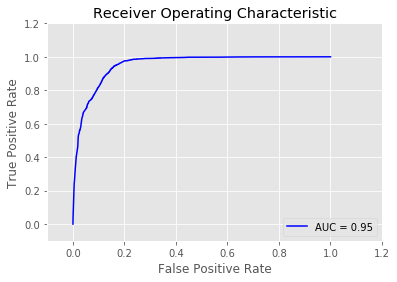

preparing validation datasets
Training until validation scores don't improve for 100 rounds.
[50]	train's auc: 0.975113	valid's auc: 0.969471
Did not meet early stopping. Best iteration is:
[44]	train's auc: 0.975211	valid's auc: 0.969327
Ant-Score: 0.33741935483870966


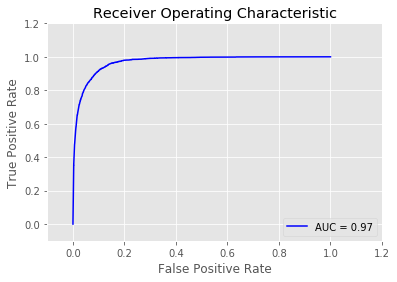

In [22]:
model_pos,score_pos = model_validation(train_df,val_df,feature_list[idx],'Normal',{})
model_neg,score_neg = model_validation(train_df,val_df,feature_list[idx],'Fraud',{})

In [ ]:
val_pos = model_pos.predict(val_df[predictors],num_iteration=model_pos.best_iteration)
val_neg = model_neg.predict(val_df[predictors],num_iteration=model_neg.best_iteration)
val_r=pd.DataFrame()
val_r['score_pos'] = 1-val_pos
val_r['score_neg'] = val_neg


In [ ]:
val_r['score'] = val_r['score_pos']*0.1  + val_r['score_neg'] *0.9
a,b,c = atecml.data.accuracy_validation(val_df['Fraud'],val_r['score'])

In [ ]:
test_df = atecml.data.load_test()
y_proba_pos = model_pos.predict(test_df[predictors],num_iteration=model_pos.best_iteration)
y_proba_neg = model_neg.predict(test_df[predictors],num_iteration=model_neg.best_iteration)

In [ ]:
result=pd.DataFrame()
result['id'] = test_df['id']
result['score_pos'] = 1-y_proba_pos
result['score_neg'] = y_proba_neg
result['score'] = result['score_pos']*0.1  + result['score_neg'] *0.9

In [ ]:
result[['id','score']].to_csv('./submit_2018_06_26_02.csv',index=False)